In [ ]:
!pip install torchvision -qqq
!pip install torchinfo -qqq

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torchvision import transforms
from torchinfo import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ERA_v1/Session17/dev4

Mounted at /content/drive/
/content/drive/MyDrive/ERA_v1/Session17/dev4


In [ ]:
from transformer_model.common_model import Transformer
from super_repo import data_setup, engine, utils
from super_repo.utils import plot_loss_curves

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
image_path = "pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Set the batch size
from transformer_model.datamodules.vit_datamodule import create_dataloaders
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7834cc665240>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

In [ ]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# HWC>>N P*P.C
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [ ]:
vit_model = Transformer(n_heads=12, block_size=16, num_layers=12, num_classes=len(class_names),algorithm="VIT")

In [ ]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit_model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Transformer (Transformer)                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [ ]:
#vit = Transformer(n_heads=12, block_size=16, num_layers=12, num_classes=len(class_names),algorithm="VIT")

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5555 | train_acc: 0.2773 | test_loss: 2.5882 | test_acc: 0.5417
Epoch: 2 | train_loss: 2.1996 | train_acc: 0.3047 | test_loss: 1.6803 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.3579 | train_acc: 0.3320 | test_loss: 1.1665 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2111 | train_acc: 0.2891 | test_loss: 1.0127 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1357 | train_acc: 0.4023 | test_loss: 1.2577 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1384 | train_acc: 0.3906 | test_loss: 1.2250 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1646 | train_acc: 0.3164 | test_loss: 1.2374 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.3148 | train_acc: 0.2891 | test_loss: 1.1284 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1275 | train_acc: 0.3242 | test_loss: 1.1443 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1460 | train_acc: 0.3086 | test_loss: 1.1668 | test_acc: 0.1979
Epoch: 11 | train_loss: 1.1958 | train_acc: 0.2930 | test_loss: 1.0407 | test_acc: 0.5417
Epoch: 12 | train_l

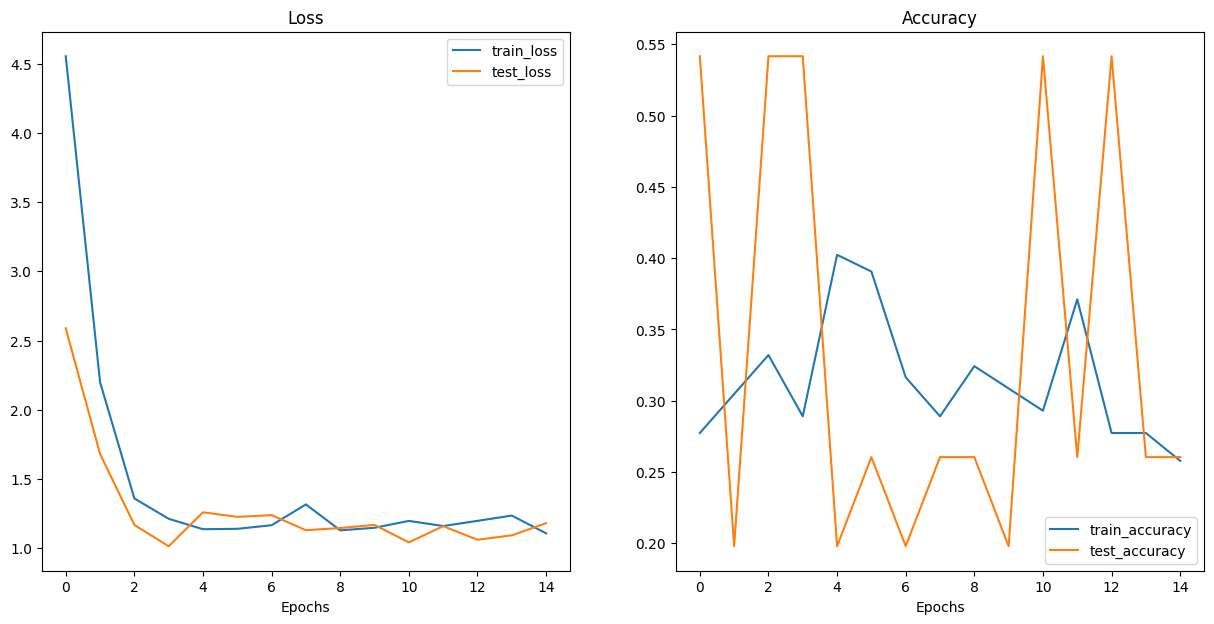

In [ ]:
# Plot our ViT model's loss curves
plot_loss_curves(results)